# DL Lab 3.1 - Homework - Text Generation

In this lab, you will generate text using character-based Neural Networks. You will work on a dataset of Tweets by Donald Trump as provided by the [Trump Twitter Archive](https://www.thetrumparchive.com) by Brendan Brown. Given a sequence of characters from this text data, e.g, "*Make Americ*", you will train models to predict the next character in the sequence ("*a*").

Trying to predict the unpredictable, this lab is meant to contrast three approaches:

(1) using a fully-connected neural network,
(2) using a fully convolutional network, and
(3) using a type of Recurrent Neural Networks (RNNs) based on Gated Recurrent Unit (GRU) cells.

***

**After completing this homework you will be able to**

- Process text data in terms of **character vectorization** and **sequence slicing** for **batched dataset generation**.
- Build **RNN models** based on **GRU** cells.
- Use trained models for **text generation**.

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=102963) in Moodle.

Let's get started!

**Note**: Training Neural Networks is a computationally expensive process. Most of the computations can be parallelized very efficently, making them a perfect fit for GPU-acceleration. In order to enable a GPU for your Colab session, do the following steps:
- Click '*Runtime*' -> '*Change runtime type*'
- In the pop-up window for '*Hardware accelerator*', select '*GPU*' 
- Click '*Save*'

# 0 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.3.0
Found GPU at: /device:GPU:0

Tue Dec  8 02:48:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Download and Prepare the Data
Execute the cells below to download the data provided by the [Trump Twitter Archive](https://www.thetrumparchive.com)

In [2]:
#@title Dataset Downloader

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    
dataset_file = '/tmp/tweets.csv'
download_file_from_google_drive('1HE_ezCVWG7JSy5fDSASAmrkmUUbPpWAC', dataset_file)


In [3]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

We will use [pandas](https://pandas.pydata.org/docs/) for importing and cleaning of the data. Let's load the data and see how it is structured:

In [4]:
import pandas as pd

tweets = pd.read_csv(dataset_file, )
tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59


We will clean the data by removing Retweets, citation tweets, urls etc. Also, we will keep only popular tweets (having $ \geq 10^4$ likes) and tweets with a minimum of 50 characters. In addition, we will convert all characters to lowercase and keep only alphanumeric characters:

In [5]:
print('Initial amount of Tweets:',len(tweets))
# remove retweets
tweets.drop(tweets[tweets.isRetweet == 't'].index, inplace=True)
# remove unpopular tweets
tweets.drop(tweets[tweets.favorites < 1e4].index, inplace=True)
# convert to lowercase
tweets.text = tweets.text.str.lower()
# remove urls from tweets
tweets.text.replace(regex=r'https?:\/\/(www\.)?[-a-z0-9@:%._\+~#=]{1,256}\.[a-z0-9()]{1,6}\b([-a-z0-9()@:%_\+.~#?&\/=]*)', value='', inplace=True)
# remove citation tweets
tweets.drop(tweets[tweets.text.str.startswith('"""')].index, inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('"via ')].index, inplace=True)
# remove non alphanumeric chars
tweets.text.replace(regex=r'[^a-z0-9,. ]', value='', inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('    ')].index, inplace=True)
# remove short tweets
tweets.drop(tweets[tweets.text.map(len) < 50].index, inplace=True)
print('Remaining Tweets:',len(tweets))

Initial amount of Tweets: 55090
Remaining Tweets: 14271


Next, we will put the tweets' text into a list and create a vocabulary of all unique characters. Note that we add another distinct character `&` at index `0`. We will use this character for sequence padding in Section 4.

In [6]:
tweets = tweets.text.to_list()

vocabulary = ['&'] + list(set(char for tweet in tweets for char in tweet))
print('{} unique characters'.format(len(vocabulary)))

40 unique characters


As discussed in the video, we need a vectorized representation of the characters. The next cell creates lookup dictionaries for converting all characters to indices (`char2idx`) and vice versa (`idx2char`):

In [7]:
# Create a mapping from unique characters to indices and vice versa
char2idx = {u:i for i, u in enumerate(vocabulary)}
idx2char = dict(map(reversed, char2idx.items()))

print(char2idx)
print(idx2char)

{'&': 0, '5': 1, 'a': 2, 'v': 3, '8': 4, 'd': 5, 'g': 6, 'b': 7, 's': 8, 'z': 9, 'x': 10, 'l': 11, 'u': 12, 'h': 13, 'j': 14, '4': 15, 'i': 16, 'o': 17, 'n': 18, 't': 19, 'm': 20, ',': 21, '1': 22, '3': 23, ' ': 24, 'w': 25, 'q': 26, 'c': 27, '6': 28, '2': 29, '0': 30, 'f': 31, 'p': 32, '9': 33, 'e': 34, 'r': 35, '7': 36, 'y': 37, 'k': 38, '.': 39}
{0: '&', 1: '5', 2: 'a', 3: 'v', 4: '8', 5: 'd', 6: 'g', 7: 'b', 8: 's', 9: 'z', 10: 'x', 11: 'l', 12: 'u', 13: 'h', 14: 'j', 15: '4', 16: 'i', 17: 'o', 18: 'n', 19: 't', 20: 'm', 21: ',', 22: '1', 23: '3', 24: ' ', 25: 'w', 26: 'q', 27: 'c', 28: '6', 29: '2', 30: '0', 31: 'f', 32: 'p', 33: '9', 34: 'e', 35: 'r', 36: '7', 37: 'y', 38: 'k', 39: '.'}


Let's create some utility functions for converting a text to sequence as well as a sequence to text:

In [8]:
def sequence_to_text(sequence):
  ''' Convert input sequence of character indices `sequence` to text. '''
  text = [idx2char.get(char_idx) for char_idx in np.array(sequence) if char_idx]
  return ''.join(text)

def text_to_sequence(text):
  ''' Convert input text `text` into sequence of character indices. '''
  sequence = [char2idx.get(char) for char in text]
  return sequence

print(text_to_sequence('foo bar'))
print(sequence_to_text(text_to_sequence('foo bar')))

[31, 17, 17, 24, 7, 2, 35]
foo bar


# 2 - Multi Layer Perceptron

## 2.1 - Data Preparation for MLP

As discussed in DL lab video 3.1, the MLP and FCN models will be fed with a coherent list of input characters, e.g., 16 characters. Given this input of 16 characters, the training objective for these models is to predict the next character.

As we cannot use sequential data as is, we will join all tweets into a single one, i.e., we merge all tweets into one large list of characters.

In [9]:
# length of input sequence
seq_length_mlp = 16

combined_text = ' '.join([tweet for tweet in tweets])
combined_sequence = text_to_sequence(combined_text)

Next, we can use TensorFlows [Dataset module](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for slicing the combined text into pieces containing 17 characters each. For slicing, we can simply use the [`batch` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) on our dataset:

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(combined_sequence)
sequences_mlp = dataset.batch(seq_length_mlp+1, drop_remainder=True)

Our dataset now consist of samples, and each of them contains 17 characters. Next, we split these samples into input samples that contain the first 16 characters, and target samples that contain the last (17th) characters: 

In [11]:
def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[-1]
  return input_sequence, target_sequence

dataset_mlp = sequences_mlp.map(split_input_target)
dataset_mlp

<MapDataset shapes: ((16,), ()), types: (tf.int32, tf.int32)>

Let's check few input and target samples:

In [12]:
for input_sample, target_sample in dataset_mlp.take(5):
  print('Input sample: "{}"'.format(sequence_to_text(input_sample)))
  print('Target sample: "{}"'.format(sequence_to_text([target_sample])))
  print()

Input sample: "i was thrilled t"
Target sample: "o"

Input sample: " be back in the "
Target sample: "g"

Input sample: "reat city of cha"
Target sample: "r"

Input sample: "lotte, north car"
Target sample: "o"

Input sample: "lina with thousa"
Target sample: "n"



As you can see, the dataset now contains of tuples of input and target samples. For training, we need to group these tuples into batches:

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset_mlp = dataset_mlp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_mlp

<BatchDataset shapes: ((None, 16), (None,)), types: (tf.int32, tf.int32)>

## 2.2 - Model Definition and Training

Let's create the MLP model consisting of *three hidden fully connected layers* with *1024 neurons*, *ReLU activation*, and `0.2` *dropout rate*. Character prediction is performed by a last *fully connected layer* with *softmax activation*.

You should be pretty familiar with this already. Complete the model as defined in the DL lab video 3.1.

**Task**: Complete the method `build_model_mlp` for creating the MLP model.

In [16]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_mlp(vocabulary_size, embedding_dim, input_length, summary=True):

  inputs = layers.Input(shape=(input_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)
  x = layers.Flatten()(x)

  ### START YOUR CODE HERE ###  (≈7 LOC)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  out = layers.Dense(vocabulary_size,activation='softmax')(x)

  ### END YOUR CODE HERE ###

  model = Model(inputs, out, name='multi_layer_perceptron')
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

Next we create an instance of the MLP model and train it for  30 epochs:

In [17]:
EMBEDDING_DIM = 32
VOCABULARY_SIZE = len(vocabulary)

mlp_model = build_model_mlp(VOCABULARY_SIZE, EMBEDDING_DIM, seq_length_mlp)
mlp_history = mlp_model.fit(dataset_mlp, 
                            epochs=30)

Model: "multi_layer_perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 16, 32)            1280      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)   

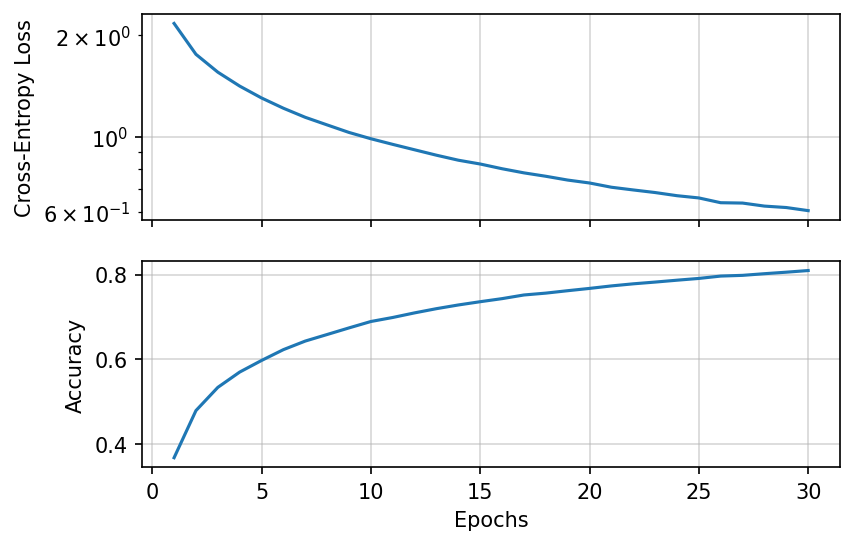

In [18]:
plot_history(mlp_history)

## 2.2 - Text Generation

If we want to use the trained model generating text, we repeatedly forward propagate a sequence of 16 characters through the model and append the predicted character to the sequence of generated text. In every step, we take the last 16 characters as input for out model.

In [19]:
def generate_text_mlp(model, start_string, num_generate = 100):
  # Convert start string to indices
  seed_sequence = text_to_sequence(start_string)
  generated_text = seed_sequence

  for i in range(num_generate):
    # feed last 16 characters into model
    seed_sequence = tf.expand_dims(generated_text[-16:], 0)
    predictions = model(seed_sequence)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)
    predicted_id = np.argmax(predictions)

    # append predicted char
    generated_text.append(predicted_id)

  return sequence_to_text(generated_text)

Let's see what your model generates:

In [20]:
print(generate_text_mlp(mlp_model, 'many are saying '))
print(generate_text_mlp(mlp_model, 'any are saying i')) # shift invariance

many are saying a big fally in our decision with the u.s. the whitehing in the can any the fake news media. we are b
any are saying in the past of the 2020 and boom ot prople whole so with a fantastic. we will be a great governor, th


# 3 - Fully Convolutional Network

## 3.1 - Data Preparation
We will use the same data as aleady prepared for the MLP model. So, nothing to do here...

## 3.2 - Model Definition and Training

Next, create a FCN architecture consisting of stacks of Conv1D layers and MaxPooling1D layers. You may just create your very own architecture or use the one detailed in the lab 3.1 video.

**Task**: Complete the method `build_model_cnn` for creating a fully convolutional model for predicting the next character of a given input sequence of characters.

In [78]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_cnn(vocabulary_size, embedding_dim, input_length, summary=True):

  inputs = layers.Input(shape=(input_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)

  ### START YOUR CODE HERE ###  (≈8 LOC)
  x= layers.Conv1D(filters = 64,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  x= layers.Conv1D(filters = 64,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  x = layers.MaxPool1D(2)(x)
  x= layers.Conv1D(filters = 128,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  x= layers.Conv1D(filters = 128,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  x=layers.MaxPool1D(2)(x)
  x= layers.Conv1D(filters = 256,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  x= layers.Conv1D(filters = 256,
      kernel_size = 3,
      padding="same",
      activation = 'relu')(x)
  ### END YOUR CODE HERE ###

  out = layers.Conv1D(vocabulary_size, x.shape[1], activation='softmax')(x)

  model = Model(inputs, out, name='fully_convolutional_model')

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

Model: "fully_convolutional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 16, 32)            1280      
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16, 64)            6208      
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 8, 128)            24704     
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 8, 12

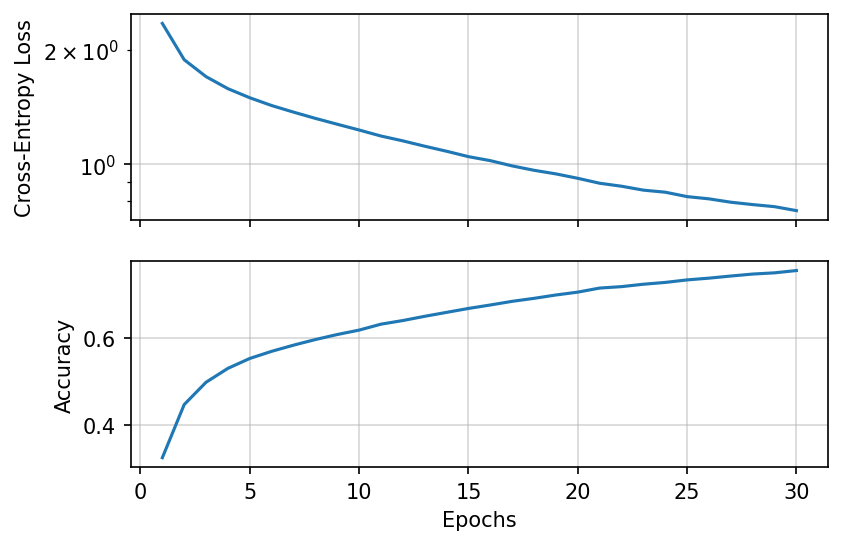

In [79]:
cnn_model = build_model_cnn(VOCABULARY_SIZE, EMBEDDING_DIM, seq_length_mlp)
cnn_history = cnn_model.fit(dataset_mlp,
                            epochs=30)
plot_history(cnn_history)

## 3.3 - Text Generation
Let's see what your model generates:

In [82]:
print(generate_text_mlp(cnn_model, 'many are saying '))
print(generate_text_mlp(cnn_model, 'any are saying i')) # shift invariance
print(generate_text_mlp(cnn_model, 'many are saying im the')) # longer sequences

many are saying it day way on the way intil future, we have been us very difference buddua there are non the probald
any are saying it day way on the way intil future, we have been us very difference buddua there are non the probald 
many are saying im the wayed and puppetc irnal, and real is compories are doing in friend about he the day there has been 


# 4 - Recurrent Neural Network

## 4.1 - Data Preparation
We train the RNN in a sequence-to-sequence fashion. In detail, we have an input sequence of characters, and a corresponding target sequence of characters that is shifted by 1 character.
In addition, instead of sampling from one merged large sequence, we will keep the original separated sequences. So, we start by converting all tweets into their vectorized representation:


In [83]:
sequences = [text_to_sequence(tweet) for tweet in tweets]

The original tweets, hence also the vectorized sequences, have different lengths. For arranging them in a dataset of tensors, we need all sequences to have the same length.

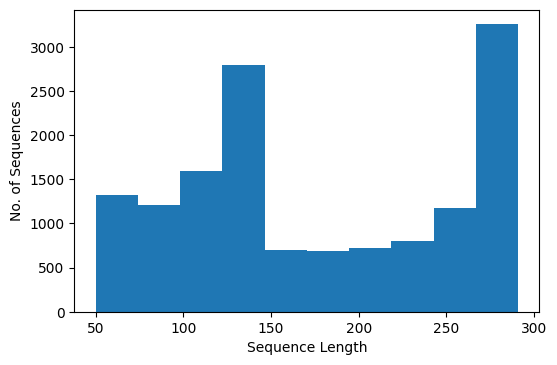

In [84]:
from matplotlib import pyplot as plt

plt.figure(dpi=100)
plt.hist([len(x) for x in sequences])
plt.xlabel('Sequence Length')
plt.ylabel('No. of Sequences')
plt.show()

As we don't want to loose information by cutting all sequences to the shortest one, we will instead pad all sequences with a defined value, e.g., `0` (by default).

Tensorflow comes with a [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) method, that will do the padding:

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = pad_sequences(sequences, 
                          padding='post',
                          value=0)

Now we can create a TF dataset and take a look on some examples:

In [86]:
dataset = tf.data.Dataset.from_tensor_slices(sequences)

for item in dataset.take(5):
  print(sequence_to_text(item))

print('\nSequence length:', sequences.shape[1])

i was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 
the unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this system, even though much smaller amp  with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots amp fraud
im running as a proud democrat, for the senate. sleepy joe biden today. its only going to get worse. it is not sustainable for our county  china will own us
huge win today for the united states and for peace in the world. sudan has agreed to a peace and normalization agreement with israel with the united arab emirates and bahrain, thats three arabcountries to have done so in only a matter of weeks. more will follow 
nobody is showing up for obamas hate laced 

Now we have a dataset of sequences with 291 elements each. For training, we need to split these sequences into input and target sequences. Each will have 290 elements, but the text in the target sequences is shifted one character to the right:

In [87]:
def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[1:]
  return input_sequence, target_sequence

dataset = dataset.map(split_input_target)
print(dataset)

<MapDataset shapes: ((290,), (290,)), types: (tf.int32, tf.int32)>


Let's take a look on few examples:

In [88]:
for input_sample, target_sample in dataset.take(3):
  print('Input sequence: "{}"'.format(sequence_to_text(input_sample)))
  print('Target sequence: "{}"'.format(sequence_to_text(target_sample)))
  print()

Input sequence: "i was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 "
Target sequence: " was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first thank you for a wonderful evening kag2020 "

Input sequence: "the unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this system, even though much smaller amp  with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots amp fraud"
Target sequence: "he unsolicited mail in ballot scam is a major threat to our democracy, amp the democrats know it. almost all recent elections using this 

Finally, we group these samples into mini-batches of size 64 and shuffle them:

In [89]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EMBEDDING_DIM = 32
VOCABULARY_SIZE = len(vocabulary)
sequence_length = sequences.shape[1]

In [90]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 290), (64, 290)), types: (tf.int32, tf.int32)>


## 4.2 - Model Definition and Training

Finally, you will design the architecture of the RNN model using Keras' Functional API. Please note that we need to define the batch size for using sequential models. Instead of defining the `input_shape`, we will thus define the `batch_input_shape`.

The architecture is very simple, i.e., you will just add a [GRU layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) on top of the Embedding layer. You may use a GRU with 1024 units. Also, remember to set the `return_sequences` parameter accordingly.

Then stack a Dropout layer with `.2` dropout rate and a final Dense layer wit softmax activation for classification across the characters of the vocabulary.

**Task**: Complete the function `build_model_gru` for creating the defined RNN model.

In [91]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_gru(vocabulary_size, embedding_dim, batch_size, sequence_length, summary=True):
  
  inputs = layers.Input(batch_input_shape=(batch_size, sequence_length-1,))
  
  x = layers.Embedding(vocabulary_size,
                       embedding_dim)(inputs)
  
  ### START YOUR CODE HERE ###  (≈3 LOC)
  x = layers.GRU(1024,
                 return_sequences=True,
                 stateful=True,
      )(x)
  x = layers.Dropout(0.2)(x)
  out = layers.Dense(vocabulary_size,activation='softmax')(x)
  ### END YOUR CODE HERE ###
  
  model = Model(inputs, out, name='gated_recurrent_unit')

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

You may now build the model and train it for 30 epochs.

Model: "gated_recurrent_unit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(64, 290)]               0         
_________________________________________________________________
embedding_31 (Embedding)     (64, 290, 32)             1280      
_________________________________________________________________
gru (GRU)                    (64, 290, 1024)           3250176   
_________________________________________________________________
dropout_6 (Dropout)          (64, 290, 1024)           0         
_________________________________________________________________
dense_8 (Dense)              (64, 290, 40)             41000     
Total params: 3,292,456
Trainable params: 3,292,456
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
222/222 [==============================] - 27s 121ms/step - loss: 1.8487 - accuracy: 0

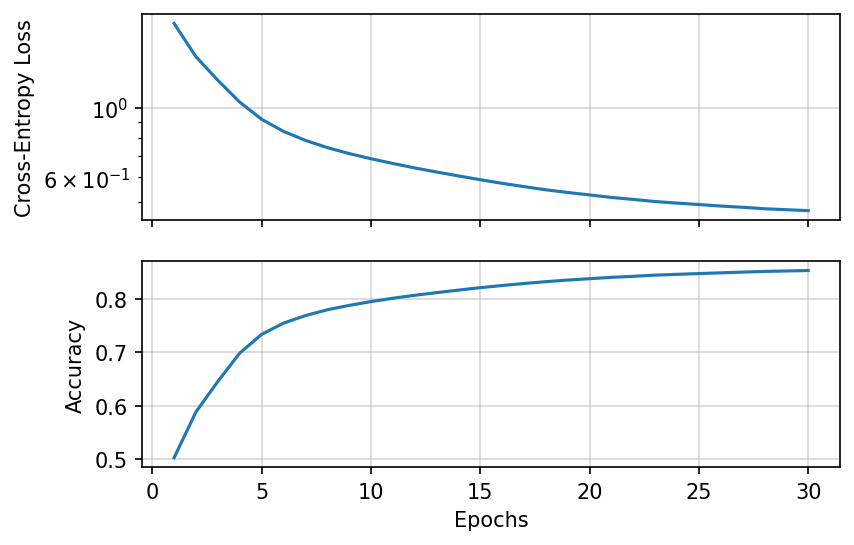

In [92]:
gru_model = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, BATCH_SIZE, sequence_length)
gru_history = gru_model.fit(dataset, 
                            epochs=30
                            )
plot_history(gru_history)

In [93]:
gru_history = gru_model.fit(dataset, 
                            epochs=30
                            )

Epoch 1/30
222/222 [==============================] - 30s 135ms/step - loss: 0.4675 - accuracy: 0.8543
Epoch 2/30
222/222 [==============================] - 30s 137ms/step - loss: 0.4640 - accuracy: 0.8552
Epoch 3/30
222/222 [==============================] - 30s 134ms/step - loss: 0.4611 - accuracy: 0.8559
Epoch 4/30
222/222 [==============================] - 30s 135ms/step - loss: 0.4600 - accuracy: 0.8562
Epoch 5/30
222/222 [==============================] - 30s 136ms/step - loss: 0.4564 - accuracy: 0.8572
Epoch 6/30
222/222 [==============================] - 30s 137ms/step - loss: 0.4546 - accuracy: 0.8578
Epoch 7/30
222/222 [==============================] - 31s 137ms/step - loss: 0.4528 - accuracy: 0.8581
Epoch 8/30
222/222 [==============================] - 30s 135ms/step - loss: 0.4500 - accuracy: 0.8588
Epoch 9/30
222/222 [==============================] - 30s 137ms/step - loss: 0.4481 - accuracy: 0.8593
Epoch 10/30
222/222 [==============================] - 30s 135ms/step - l

## 4.3 - Generate Text

Whereas your `gru_model` was trained on batches of size 64, we will perform text generation using only a single sample per batch, i.e., using a batch size of 1. However, sequence models only accept a **fixed batch size**. Hence, we need to 
1. Save the weights of the trained `gru_model`.
2. Rebuild another model `tweety` with same architecture but using a batch size of 1.
3. Load the weights of the `gru_model` into the `tweety` model.

You may conviently use the `save_weights` and `load_weights` methods of the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

**Task**: Complete the code below for saving and restoring model weights as well as creating another GRU model (call `build_model_gru`) with batch size of 1.

In [95]:
weights_file = '/tmp/gru_model_weights'

### START YOUR CODE HERE ###  (≈3 LOC)

# 1) Save weights of `gru_model`
gru_model.save_weights("ckpt")
# 2) Build `tweety` model
tweety = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, 1, sequence_length)
# 3) Load the saved weights into `tweety` model
tweety.load_weights("ckpt")
### END YOUR CODE HERE ###

Model: "gated_recurrent_unit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(1, 290)]                0         
_________________________________________________________________
embedding_33 (Embedding)     (1, 290, 32)              1280      
_________________________________________________________________
gru_2 (GRU)                  (1, 290, 1024)            3250176   
_________________________________________________________________
dropout_8 (Dropout)          (1, 290, 1024)            0         
_________________________________________________________________
dense_10 (Dense)             (1, 290, 40)              41000     
Total params: 3,292,456
Trainable params: 3,292,456
Non-trainable params: 0
_________________________________________________________________
None


The `generate_text` function in the next cell below generates the text. It is running the loop as discussed in the lab 3.1 video:
- Forward a seed string and predict next character.
- Use predicted character as next input to the model.

In [96]:
def generate_text(model, start_string, num_generate=100):
  # Convert start string
  seed_sequence = text_to_sequence(start_string)

  # Storage for generated text, init with start string
  text_generated = seed_sequence

  # Adjust for batch dimension
  seed_sequence = tf.expand_dims(seed_sequence, 0)

  # Start with fresh state
  model.reset_states()

  for i in range(num_generate):
    # Predict next characters for `seed_sequence`
    predictions = model(seed_sequence)

    # Remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # Get last predicted character idx
    predicted_id = np.argmax(predictions[-1,:])

    # Store generated character
    text_generated.append(predicted_id)

    # Prepare predicted character idx as the next input to the model
    seed_sequence = tf.expand_dims([predicted_id], 0)

  return sequence_to_text(text_generated)

In [97]:
print(generate_text(tweety, 'many are saying '))
print(generate_text(tweety, 'any are saying i'))
print(generate_text(tweety, 'many are saying im the'))
print(generate_text(tweety, 'many'))

many are saying that i am having in the national security advisor. i am leaving now for the state of israel until th
any are saying indoctrinate your country and our great military and vets. he is strong on crime, borders, and hispan
many are saying im there is also somewhere the rigged system  amp, we will be with you 
many companies are coming back to the u.s. in the house, but when you have to do with the massive tax cu


Pretty close to the original?

***

# Congratulations!

You saw how easily Recurrent Neural Networks can be trained. You might further improve the model by **increasing the amount of units** in the recurrent cell, **stacking multiple recurrent layers**, and train the model for **more epochs**. In addition, you might just replace the [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) with a [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and see whether this makes an impact.

***

You may now submit your notebook to moodle:
- Enter your email adress in the cell below.
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.